<center><b><font size=6>Machine Learning for Networks<b><center>

<left><b><font size=4>SSH Shell Attack session<b><left>                                                                   
##### Group 11

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
import time

# Models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix, classification_report

#Language Models Exploration 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from keras.models import Sequential
from keras.layers import Dense  

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score

<br>
<left><b><font size=4>Section 1 – Data exploration and pre-processing<b><left>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [3]:
def clean_session(full_session):
    return [word for word in list(filter(None, re.split(";|/|-|\||\.|=|$| ", full_session))) if word.isalpha()]

Dataset of all the SSH sessions

In [4]:
df_original = pd.read_parquet('ssh_attacks.parquet')
df=df_original.copy()
df['first_timestamp'] = pd.to_datetime(df['first_timestamp'])
df

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


**1. When are the attacks performed? Analyze the temporal series.**

In [ ]:
# Creating a new DataFrame containing only attack instances
# Excluding sessions labeled as "Harmless" with a single label
df_attacks = df.loc[~df["Set_Fingerprint"].apply(lambda x : "Harmless" in x and len(x) == 1)]
attacks_per_day = df_attacks['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_of_attacks_per_day")
attacks_per_day

The analysis of attack occurrences based on the temporal series of first_timestamp showcases a trend in attack frequency over time.
The dataset has been transformed to interpret the first_timestamp column as datetime objects for accurate temporal analysis. The subsequent process isolates attack instances within the dataset, excluding records tagged as "Harmless" with a single label.
The resulting analysis presents the number of attacks per day:

| Date_time | Attacks |
| --- | --- |
|June 4th, 2019 | 82 attacks |
|June 5th, 2019 | 124 attacks |
|June 6th, 2019 | 117 attacks |
|June 7th, 2019 | 121 attacks |
|June 8th, 2019 | 118 attacks |
| ... (continues with dates up to) |
| February 25th, 2020| 649 attacks |
| February 26th, 2020| 483 attacks |
| February 27th, 2020| 551 attacks |
| February 28th, 2020| 580 attacks |
| February 29th, 2020| 627 attacks |

This temporal series reveals fluctuations in attack intensity over time, with notable spikes and drops in attack occurrences. The observations suggest potential patterns or trends that could be further explored to understand the dynamics of these SSH shell attacks across different periods.

In [ ]:
plt.figure(figsize=(12,8))
sns.set_style("darkgrid")

sns.lineplot(
    data = attacks_per_day,
    linestyle='-',
    color= 'blue',
    legend=False
)

plt.title('Number of Attacks')
plt.xlabel("Date")
plt.ylabel("Number of attacks")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.show()

The visualization depicting attack frequencies over time reveals distinct patterns:

Between June 2019 and September 2019, there is a conspicuous decrease in attack occurrences, indicating a phase of minimal activity. Subsequently, there is a significant surge in attack instances towards the latter part of 2019, signifying a notable rise in both the frequency and intensity of attacks during this period.

This timeline underscores a stark contrast between the relatively quiet phase observed from June to September 2019 and the pronounced escalation in attack activities, particularly notable in the latter months of the year. This shift in trend emphasizes a substantial alteration in attack behavior, marked by an extended period of low activity succeeded by a considerable surge in attack incidents towards the year's end.

Moreover, at the beginning of 2020, there is a noticeable decline in attack occurrences once more. This decline follows the heightened activity observed in late 2019, representing a shift from the increased attack rates back to a decreased frequency as the year transitions into its initial months.

In [ ]:
attacks_per_year = df_attacks.groupby(df['first_timestamp'].dt.year).size().to_frame("Number_attacks").reset_index()
attacks_per_year.rename(columns={"first_timestamp": "Year"}, inplace=True)
attacks_per_year

The contrast in attack counts between the two years, with 2019 showing a significantly higher number of attacks compared to 2020, can be reasonably attributed to the limited temporal coverage of the dataset for the year 2020. With data available for only two months of 2020, the reduced number of observations in this period is expected and explains the lower count of attacks for that year compared to the extensive records available for 2019.

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(
    data = attacks_per_year,
    x = "Year",
    y = "Number_attacks",
    hue= "Year",
    palette = ['blue','orange']
)

plt.ylabel("Number of attacks")
plt.title("Number of total attacks in 2019 and 2020")
plt.show()

In [ ]:
df_attacks_2019 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2019]
df_attacks_2019_month = df_attacks_2019.groupby(df_attacks_2019["first_timestamp"].dt.month).size().to_frame("Number_attacks_2019_month").reset_index()

df_attacks_2020 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2020]
df_attacks_2020_month = df_attacks_2020.groupby(df_attacks_2020["first_timestamp"].dt.month).size().to_frame("Number_attacks_2020_month").reset_index()

In [ ]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(1,2 ,sharey=True)
plt.subplot(1,2,1)
sns.barplot(
    data = df_attacks_2019_month,
    x = "first_timestamp",
    y = "Number_attacks_2019_month",
    ax=axes[0],
    color = 'blue'  
)
plt.title("2019")
plt.xlabel("Month")
plt.ylabel("Number of attacks")

plt.subplot(1,2,2)
sns.barplot(
    data = df_attacks_2020_month,
    x = "first_timestamp",
    y = "Number_attacks_2020_month",
    ax=axes[1],
    color = 'orange'
)
plt.title("2020")
plt.xlabel("Month")
plt.ylabel("Number of attacks")

plt.tight_layout()
plt.show()

The bar charts reveal intriguing trends:

- In 2019, there is a noticeable surge in the number of attacks from months 9 to 12. A progressive increase in attack activity is observed during these months, reaching a peak towards the year's end.

- At the onset of 2020, in months 1 and 2, a relatively similar frequency of attacks is noted, approximately representing half the number of attacks compared to month 10 in 2019.

These patterns outline a significant uptick in attack activity towards the end of 2019, followed by a comparatively steady beginning in 2020 with a considerably lower number of attacks compared to the peak period of the previous year.

**1.2. Extract features from the attack sessions. How does the empirical distribution of the number of
characters in each session look like? How is the distribution of the number of word per session?**

In [ ]:
# Calculate the number of characters and words in each session
number_characters = df['full_session'].apply(lambda x: len([char for char in x if char.isalpha()]))

number_words = df['full_session'].apply(lambda x: len(clean_session(x)))

data = {"number_characters": number_characters, "number_words": number_words}
df_number_characters_words = pd.DataFrame(data = data)
df_number_characters_words

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.ecdfplot(
    data = df_number_characters_words['number_characters'],
    log_scale=True
)
plt.title("ECDF for characters")
plt.xlabel("Number of characters")
plt.ylabel("CDF")

plt.subplot(1,2,2)
sns.ecdfplot(
    data = df_number_characters_words['number_words'],
    log_scale=True
)
plt.title("ECDF for words")
plt.xlabel("Number of words")
plt.ylabel("CDF")

plt.tight_layout()
plt.show()

From the plot, it's possible to see that the distribution of words per session and the distribution of characters per session predominantly concentrate below 2000 words and below 20,000 characters, respectively.

To have a clearer idea of the distribution, we decided to limit the x-axis for both plots so that we can closely examine these two distributions

From the histograms, it is observed that the distribution of character counts per session centers is concentrated around approximately 350 characters.
Moreover, regarding the number of words per session, the distribution frequently peaks around 40 to 48 words. This indicates that sessions often contain this range of word counts, emphasizing a typical occurrence of sessions with this word count range. These insights provide a clear understanding of the common lengths observed within the attack sessions, both in terms of characters and words.

**1.3. What are the most common words in the sessions?**

In [ ]:
# Joining all text from 'full_session' into a single string
full_session = ' '.join(df['full_session'])
session_cleaned = clean_session(full_session)

In [ ]:
df_most_common_words = pd.Series(session_cleaned).value_counts().head(10)
most_common_word = df_most_common_words.idxmax()
frequency = df_most_common_words.max()
word_freq=df_most_common_words.to_dict()
most_common_word

The most common word is : 'tmp'

In [ ]:
# dictionary that holds the frequencies of the top 10 most common words
word_freq

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

 This representation emphasizes words based on their frequency in the sessions. Words that appear more frequently will be displayed larger and more prominently within the WordCloud. The interpolation='bilinear' argument enhances the image quality for better clarity. The plt.axis('off') command removes the axis for a cleaner visual appearance.

**1.4. How are the intents distributed? How many intents per session do you observe? What are the most common intents? How are the intents distributed in time?**

In [ ]:
intents_df = df[["session_id", "first_timestamp", "Set_Fingerprint"]]

# Expanding the 'Set_Fingerprint' column to individual intents and sessions
intents_df_exploted = intents_df.explode('Set_Fingerprint')
intents_df_grouped = intents_df_exploted.groupby("session_id").size().to_frame("Number_of_intents")

plt.figure(figsize=(10,8))
sns.ecdfplot(
    data = intents_df_grouped,
    legend=False
)
plt.title("ECDF for intents")
plt.xlabel("Intents")
plt.ylabel("CDF")
plt.show()

In [ ]:
intents = intents_df_exploted.groupby('Set_Fingerprint').size().sort_values(ascending=False).to_frame("Number_of_sessions")
sns.set(style="darkgrid")
plt.figure(figsize=(6,3))
sns.barplot(intents, x="Number_of_sessions", y=intents.index, color="blue", hue_order=intents.index)
plt.title('Distribution of Intents')
plt.xlabel('Number of sessions')
plt.ylabel('Type of Intents')

plt.show()

The presented bar chart shows the most common intentions found in the dataset; Discovery, Persistence and Execution lead the most used type of attacks for each of the sessions.

In [ ]:
df_intents_distribution = intents_df_exploted.groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().to_frame("Number_of_intents").reset_index()
df_intents_distribution
plt.figure(figsize=(12, 6))
sns.lineplot(
    data = df_intents_distribution,
    x = "first_timestamp",
    y = "Number_of_intents",
    hue="Set_Fingerprint",
    legend=True
)
plt.title("Distribution of the intents over the time")
plt.xlabel("Date")
plt.ylabel("Number of the intents")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

plt.show()


In [ ]:
#FIXME WHICH PLOT SHOULD WE USE ?

grid = sns.FacetGrid(df_intents_distribution, col="Set_Fingerprint", col_wrap=1, height=4, sharey=False, aspect=2)

grid.map(sns.lineplot, "first_timestamp", "Number_of_intents")

grid.set_axis_labels("Date", "Number of Intents")
grid.set_titles(col_template="{col_name}")

plt.show()

The distribution of intents unfolds as follows:

**Defense Evasion**:
No significant peaks noticed, with a few attacks observed between July and September 2019, remaining consistently low alongside 'Harmless', 'Impact', and 'Other' intents.

**Execution**:
Displays a sharp peak towards the end of 2019, notably in the last two months.

**Persistence and Discovery**:
Showcase an intriguing trend, reaching their highest peaks towards the end of 2019. These intents exhibit the highest frequency, notably surging towards the year-end, reaching maximum levels.

**1.5. How can text represented numerically? Try to convert the text into numerical representations
(vectors) through Bag of Words (BoW)**

In [5]:
df_session_cleaned = df.copy()
df_session_cleaned.update(df_session_cleaned["full_session"].apply(lambda x : clean_session(x)))
df_session_cleaned

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,"[enable, system, shell, sh, cat, proc, mounts,...",2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,"[enable, system, shell, sh, cat, proc, mounts,...",2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,"[enable, system, shell, sh, cat, proc, mounts,...",2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,"[enable, system, shell, sh, cat, proc, mounts,...",2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,"[enable, system, shell, sh, cat, proc, mounts,...",2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,"[cat, proc, cpuinfo, grep, name, wc, l, echo, ...",2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,"[cat, proc, cpuinfo, grep, name, wc, l, echo, ...",2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,"[cat, proc, cpuinfo, grep, name, wc, l, echo, ...",2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,"[cat, proc, cpuinfo, grep, name, wc, l, echo, ...",2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


In [ ]:
count_vectorizer = CountVectorizer(min_df = 0.05)
bow = count_vectorizer.fit_transform(df_session_cleaned["full_session"].apply(lambda x : " ".join(x)))

In [ ]:
df_session_cleaned_bow = pd.DataFrame(bow.toarray(), index=df_session_cleaned.index, columns = list(count_vectorizer.vocabulary_.keys()))
for feature in df_session_cleaned_bow.columns:
    df_session_cleaned_bow[feature] = normalize(df_session_cleaned_bow[feature].values.reshape(-1,1), norm="l2", axis=0)

In [ ]:
df_session_cleaned_bow = pd.concat([df_session_cleaned, df_session_cleaned_bow], axis=1)
df_session_cleaned_bow

**1.6. Associate each word in each attack session with its TF-IDF value (Term Frequency-Inverse Document Frequency)**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df = 0.05)
tfid = tfidf_vectorizer.fit_transform(df_session_cleaned["full_session"].apply(lambda x : " ".join(x)))

In [ ]:
df_session_cleaned_tfidf = pd.DataFrame(tfid.toarray(), index=df_session_cleaned.index, columns = list(tfidf_vectorizer.vocabulary_.keys()))
df_session_cleaned_tfidf = pd.concat([df_session_cleaned, df_session_cleaned_tfidf], axis=1)
df_session_cleaned_tfidf

<br>
<b>Correlation Matrix</b>

In [ ]:
df_features_bow = df_session_cleaned_bow.drop(columns=["session_id", "full_session", "first_timestamp", "Set_Fingerprint"])

In [ ]:
correlation_matrix_bow = df_features_bow.corr().abs()
plt.figure(figsize=(50,50))
sns.heatmap(correlation_matrix_bow, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.title('Correlation matrix')
plt.show()

In [ ]:
df_features_tfidf = df_session_cleaned_tfidf.drop(columns=["session_id", "full_session", "first_timestamp", "Set_Fingerprint"])

In [ ]:
correlation_matrix_tfidf = df_features_tfidf.corr().abs()

plt.figure(figsize=(50,50))
sns.heatmap(correlation_matrix_tfidf, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.title('Correlation matrix')
plt.show()

In [ ]:
pca_bow = PCA()
pca_bow.fit(df_features_bow)
explained_variance_bow = pca_bow.explained_variance_ratio_

plt.figure(figsize=(8,4))
sns.lineplot(
    data = explained_variance_bow,
    marker = "o",
    color = 'blue'
)
# Set up Seaborn style
sns.set(style="darkgrid")
plt.xticks(range(0, len(explained_variance_bow), 5))
plt.xlabel("Principal Components")
plt.ylabel("Explained variance")
plt.title("PCA")
plt.show()

In [ ]:
pca_bow = PCA(n_components=4)
pca_result_bow = pca_bow.fit_transform(df_features_bow)
pca_result_bow = pd.DataFrame(pca_result_bow, columns=[f'PC{i}' for i in range(pca_bow.n_components_)])
pca_result_bow

In [ ]:
pca_tfidf = PCA()
pca_tfidf.fit(df_features_tfidf)
explained_variance_tfidf = pca_tfidf.explained_variance_ratio_

plt.figure(figsize=(8, 4))
sns.lineplot(
    data = explained_variance_tfidf,
    marker="o",
    color = 'blue'
)
# Set up Seaborn style
sns.set(style="darkgrid")
plt.xticks(range(0, len(explained_variance_tfidf), 5))
plt.xlabel("Principal Components")
plt.ylabel("Explained variance")
plt.title("PCA")
plt.show()

In [ ]:
pca_tfidf = PCA(n_components=3)
pca_result_tfidf = pca_tfidf.fit_transform(df_features_tfidf)
pca_result_tfidf = pd.DataFrame(pca_result_tfidf, columns=[f'PC{i}' for i in range(pca_tfidf.n_components_)])
pca_result_tfidf

<br>
<left><b><font size=4>Section 2 – Supervised Learning – Classification<b><left>

In [5]:
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, multilabel_confusion_matrix, make_scorer, f1_score
import time

<br>
<div style="text-align: justify"> Classify the tactics of an attack session, based on the used words in the text and also possibly on time. Notice that each session have multiple labels. Hence you can decompose the problem into multiple binary classification problems. For each attack session, you have to solve the 7 binary classification problem, one for each possible label {'Persistence', 'Discovery', 'Defense Evasion', 'Execution', 'Impact', 'Other', 'Harmless'}. </div><br>

**2.1 Perform a split to segment the dataset into training and test dataset. If you want to standardize your dataset, fit the scaler on training set and transforming both training and test. Notice that the sklearn implementation of tf-idf already performs the standardization.**

In [ ]:
X_feature = df_features_tfidf
y_feature = df_session_cleaned["Set_Fingerprint"]

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_feature, train_size = 0.7,)

In [ ]:
print('The size of trainning set is:', len(X_train))
print('The size of test set is:', len(X_test))

In [ ]:
X_train

### Data Preprocessing

##### Standardization of the Numerical Features

As the TF-IDF pre-processing was applied previously to all the sessions, the data considered as features was already standardized. 

##### Standardization of the Categorical Features

In [ ]:
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.transform(y_test)

**Preprocessing Techniques** 
<br>
<div style="text-align: justify"> A <b>MultiLabelBinarizer</b> is a transformer that is used for multi-label classification problems, in order to handle the cases where each sample belongs to multiple classes simultaneously. The purpose of MultiLabelBinarizer is to convert a collection of sequences of labels into a binary matrix format. The binary classification of each label in the 'Set_Fingerprint' column was performed by converting the multi-class label matrix into a binary matrix, where each column represents one of the possible classes and each row represents one instance. </div><br>

<div style="text-align: justify"> <b>TF-IDF </b> (explain technique here) </div><br>

<div style="text-align: justify"> MultiLabelBinarizer is used to handle categorical variables before fitting a model, as most machine learning algorithms can only handle numerical data.</div><br>


**2.2 Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?**

<br><left><b><font size=4> Random Forest (RF)<b><left>

<div style="text-align: justify">Random Forest (RF) serves as a classification model that constructs a collection of decision trees (DT) using a randomly chosen subset of the given training set. The model aggregates the individual decisions made by each decision tree and combines their votes to make the ultimate prediction.</div>

In [ ]:
model_rf = RandomForestClassifier(n_estimators=100) 

st = time.time()
model_rf.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

In [ ]:
y_train_predictions = model_rf.predict(X_train)
y_test_predictions = model_rf.predict(X_test)

In [ ]:
# Evaluate the model's performance on the train data
accuracy = model_rf.score(X_train, y_train_mlb)
print(f"Accuracy of the 'Random Forest' model for the training set: {accuracy:.2f}")

# Evaluate the model's performance on the test data
accuracy = model_rf.score(X_test, y_test_mlb)
print(f"Accuracy of the 'Random Forest' model for test set: {accuracy:.2f}")

<br>
<left><b><font size=3 >Classification Report<b><left>

##### Training Set

In [ ]:
# FIXME WE SHOULD SPLIT BETTER THE TRAIN AND THE TEST SET, THE WARNING COMES OUT BECAUSE y_train_mlb AND 
# y_train_predictions DON'T HAVE THE SAME LABELS (IMPACT AND OTHER ARE VERY FEW)
# Evaluate performance on training set
report_training = classification_report(y_train_mlb, y_train_predictions, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_training = pd.DataFrame(report_training).transpose()
df_report_training

##### Validation Set (Test set)

In [ ]:
# Evaluate performance on test set
report_test = classification_report(y_test_mlb, y_test_predictions, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_test = pd.DataFrame(report_test).transpose()
df_report_test

<br>
<left><b><font size=3> Confusion Matrix <b><left>

##### Training Set

In [ ]:
confusion_rf_train = multilabel_confusion_matrix(y_train_mlb, y_train_predictions)

for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for '{label}':")
    print(confusion_rf_train[i], "\n")

In [ ]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    plt.imshow(confusion_rf_train[i], cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.tight_layout()
plt.show()

##### Validation Set

In [ ]:
confusion_rf_test = multilabel_confusion_matrix(y_test_mlb, y_test_predictions)

for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for '{label}':")
    print(confusion_rf_test[i], "\n")   

In [ ]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}' in Test Set")
    plt.imshow(confusion_rf_test[i], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

<br>
<left><b><font size=4>K-Nearest Neighbors (KNN)<b><left>

<div style="text-align: justify">K-Nearest Neighbors (KNN) operates as a supervised learning classifier that relies on the concept of proximity to perform classifications or predictions for individual data points. Its fundamental principle is grounded in the notion that similar data points tend to cluster together. In the context of classification tasks, KNN assigns a class label to a data point by considering the majority vote of its nearest neighbors. Put simply, it selects the label that is most prevalent among the neighboring data points in close proximity to the one being evaluated.</div><br>

In [ ]:
knn = KNeighborsClassifier()

st = time.time()
knn.fit(X_train, y_train_mlb)
et = time.time()

elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

In [ ]:
predictions_train = knn.predict(X_train) 
predictions_test = knn.predict(X_test)

In [ ]:
accuracy = knn.score(X_train, y_train_mlb)
print(f"Accuracy of the k-NN model for the training set: {accuracy:.2f}")

accuracy = knn.score(X_test, y_test_mlb)
print(f"Accuracy of the k-NN model for the test set: {accuracy:.2f}")

<br>
<left><b><font size=3 >Classification Report<b><left>


##### Training Set

In [ ]:
# Classification Report for training set
report_train_knn = classification_report(y_train_mlb, predictions_train, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_train = pd.DataFrame(report_train_knn).transpose()
print("Classification Report for Trainning set:")
df_report_train

##### Validation Set

In [ ]:
# Classification Report for test set
report_test_knn = classification_report(y_test_mlb, predictions_test, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_test_knn = pd.DataFrame(report_test_knn).transpose()
print("Classification Report for Test set:")
df_report_test_knn

<br>
<left><b><font size=3> Confusion Matrix <b><left>

The code presented below prints a series of confusion matrices for each class, displaying True-Positive (top-left), False-Negative (bottom-left), False-Positive (top-right), and True-Negative (bottom-right) counts.
- True Positives (TP): Predicted correctly as positive.
- False Positives (FP): Predicted as positive but actually negative.
- False Negatives (FN): Predicted as negative but actually positive.
- True Negatives (TN): Predicted correctly as negative.

Each value in the confusion matrix represents the count of instances falling into these categories for a specific label.

In [ ]:
# Evaluate with a confusion matrix and classification report
confusion_knn_test = multilabel_confusion_matrix(y_test_mlb, predictions_test)
for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for {label}:")
    print(confusion_knn_test[i], "\n")

In [ ]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    plt.imshow(confusion_knn_test[i], cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

<div style="text-align: justify"> To know whether the model is underfitting or overfitting, we must first define these two terms. <br>
<div style="text-align: justify"><br><b>Underfitting</b> occurs when a model is too simple to capture the underlying patterns in the training data, resulting in poor performance even on the training set.  One indicator used to identify this modelling error is to look at the results; if both training and validation/testing performance are poor, the model is considered to be underfitted.</div><br>

<div style="text-align: justify"><b>Overfitting</b> occurs when a model not only learns the underlying patterns in the training data, but also captures noise and random fluctuations, causing it to perform poorly on new and unknown data. One indicator used to identify this modelling error is to look at the results, if the model performs well on training data but poorly on validation or test data, it is considered overfitted.</div><br>

<div style="text-align: justify">Once these two terms have been defined, it is possible to move on to the results obtained for both models. It is important to mention that, for both tests performed with the different classifiers, the default parameters were used.</div><br>
<div style="text-align: justify">For the <b>Random Forest (RF)</b> case, the default parameter implied the number of estimators equal to 100, and the tree depth was set to <i>'None'</i>. On the other hand, for the <b>K-Nearest Neighbor (KNN)</b> classifier, the number of estimators was set to 5, the leaf size to 30 and the type of distance calculation was <i>'Euclidean distance'</i> (p=2), all default parameters of the classifier.</div><br>
    
<b> Random Forest (RF)</b>
<div style="text-align: justify"> In the classification report of the training and test sets, for most of the classes, accuracy, recall and F1 score are slightly lower in the test set compared to the training set. This was expected, as models tend to generalise slightly worse with unseen data. However, the drop in performance is not significant, which indicates that the model still performs well on the test set. Furthermore, the accuracy obtained for the training set was 99%, while 98% for the test set.<br><br>
    
<div style="text-align: justify">As can be seen in the validation set report, the model was not able to correctly classify instances of the <i>'Impact'</i> class, performing very poorly (0%) on all precision, recall and F1 score metrics. This result could be due to the default parameters set to train the model.  Tree depth is one of the most important parameter for tuning the model, as it sets the stop condition that limits the number of splits or levels deep a decision tree can go.</div><br>

<div style="text-align: justify">To enhance the classifier results, it is necessary to adjust the maximum depth of the decision trees when performing hyperparameter fitting for a random forest model. The <i>'weighted avg'</i> metric also showed a decrease in performance on the test set, indicating that the model does not perform as well on the test set across all classes, considering the distribution of classes. Overall, the performance metrics on the test set remain high, indicating that the overfitting is not critical. </div><br>

<b> K-Nearest Neighbor (KNN)</b>

<div style="text-align: justify">On the other hand, the classification report obtained for the KNN classifier showed a small difference between the training set and the validation set, for the test set the values obtained for each of the metrics; accuracy, recall, f1-score, were slightly lower compared to the results obtained for the training set.</div><br>

<div style="text-align: justify"> For the <i>'Impact'</i> class, the metrics derived in the training set were significantly lower compared to the validation set, for all metrics. This improvement in the accuracy, recall and f1-score parameters for the <i>'Impact'</i> class in the test set indicates that the model's predictions for this class are more accurate and reliable when evaluated with new, unseen data.  Producing a recall of 50%, which means, that the model only correctly predicted this class for 50% of the evaluated intents. </div><br>

<div style="text-align: justify">The difference obtained in this class for the training and validation sets suggests that the model did not sufficiently fit the <i>'Impact'</i> class during training, and then after the selection of the nearest neighbour from the test set, the model adjusted its predictions to better capture the features of the <i>'Impact'</i> class. However, it is important to note that the KNN classifier does not fit the data, it does not learn from the model, it only calculates the distance to the nearest points and selects the class according to the majority result of the nearest neighbours.</div><br>

<div style="text-align: justify"> In general, the observed results do not indicate underfitting or overfitting, in fact, the average accuracy obtained in the classification report was 99%, matching with the obtained in the calculated accuracy score (98% for both sets). The high values of the <i>'micro-average'</i> in both sets suggest a good overall performance of the model. While the <i>'macro-average'</i> values are higher only in the test set, indicating that the model performs better after calculating the Euclidean distance of each point.</div><br>


**2.3 Tune the hyper-parameters of the models through cross-validation. How do performance vary?**

#### Grid Search Technique

<div style="text-align: justify">Hyperparameters are settings that control the learning process of machine learning models. While the parameters are learned during the training process, the hyperparameters are set before the training starts. Therefore, in order to find the parameters that best fit the performance of the model, the GridSearch technique was applied. This technique applies all possible combinations of hyperparameters, resulting in a set of parameters that will improve the performance of the model.</div>

#### Random Forest

In [ ]:
#GRID SEARCH
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
params = {'n_estimators': [3, 50, 100], 'max_depth': [100, 1000, 10000] } #'criterion' :['gini', 'entropy']}

# Instantiate the grid search model
gs_rf = GridSearchCV(model_rf, param_grid = params, scoring='f1_macro', cv = 5, verbose = 1) 
# scoring='accuracy'
# cv: that's the number of fold for the cross-validation
# verbose: specifies the verbosity level of the GridSearchCV object. 

# Trainning the model
st = time.time()
gs_rf.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

In [ ]:
best_params_rf = gs_rf.best_params_
print(f"The best combination of parameters the Grid Search has found is: {best_params_rf}")
print("Best F1-Score: {:.2f}".format(gs_rf.best_score_))

#### Ask to the prof which graph we should use -------------------------------------------------------------------------

In [ ]:
# Bar plot

In [ ]:
# Let's print the f1 macro reached for each combination
y = gs_rf.cv_results_["mean_test_score"].tolist()
x = [i for i in range (1, len(y)+1)]
mean_test_score_df = pd.DataFrame()
mean_test_score_df["f1_macro"] = y

plt.figure(figsize=(8, 6))
sns.barplot(x = mean_test_score_df.index, y = "f1_macro", data = mean_test_score_df, color='blue')

# Add a title and labels to the plot
plt.title('F1-macro Scores for Different Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-macro Score')
plt.show()

In [ ]:
# Heatmap plot

In [ ]:
results_rf = pd.DataFrame(gs_rf.cv_results_)
results_rf

In [ ]:
# We create a pivot table 
scores_rf = results_rf.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
scores_rf

In [ ]:
sns.heatmap(scores_rf, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('param_max_depth')
plt.ylabel('param_n_estimators')
plt.title('Mean F1-Score over all folds for each combination of parameters')
plt.show()

#### K-Nearest Neighbor

In [ ]:
params = {'n_neighbors': [5, 10, 20], 'leaf_size': [10, 70, 100]}        #'metric': ['euclidean', 'manhattan']} 
grid_search_knn = GridSearchCV(knn, params, scoring='f1_macro', cv = 5, verbose=1)
# scoring = 'accuracy'

st = time.time()
grid_search_knn.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

In [ ]:
best_params_knn = grid_search_knn.best_params_
print(f"The best combination of parameters the Grid Search has found is: {best_params_knn}")
print("Best F1-Score: {:.2f}".format(grid_search_knn.best_score_))

#### Aks to the prof which graph we should use --------------------------------------------------------------------------

In [ ]:
#Bar plot

In [ ]:
# Let's print the f1 macro reached for each combination
y = grid_search_knn.cv_results_["mean_test_score"].tolist()
x = [i for i in range (1, len(y)+1)]
mean_test_score_df = pd.DataFrame()
mean_test_score_df["f1_macro"] = y
#print(mean_test_score_df)

sns.barplot(x = mean_test_score_df.index, y = "f1_macro", data = mean_test_score_df, color='blue')
# Add a title and labels to the plot
plt.title('F1-macro Scores for Different Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-macro Score')

# Display the plot
plt.show()

In [ ]:
# Heatmap plot

In [ ]:
results_knn = pd.DataFrame(grid_search_knn.cv_results_)
results_knn

In [ ]:
# We create a pivot table before create the heatmap
scores_knn = results_knn.pivot(index='param_leaf_size', columns='param_n_neighbors', values='mean_test_score')
scores_knn

In [ ]:
sns.heatmap(scores_knn, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('param_n_neighbors')
plt.ylabel('param_leaf_size')
plt.title('Mean F1-score over all folds for each combination of parameters')
plt.show()

**2.4. Comments on the results for each on the intents.**

<div style="text-align: justify">The aim of this analysis is to assess the predictive capability of two models in classifying attack labels. The models will be evaluated based on the hyperparameters identified previously.</div>

##### Evaluation of Random Forest with tuned parameters

In [ ]:
# Random Forest with the hyperparameters
model_rf_tunned = RandomForestClassifier(n_estimators = 50, max_depth = 10000)

st = time.time()
# Trainning the model
model_rf_tunned.fit(X_train, y_train_mlb)
et = time.time()
# get the execution time
elapsed_time = et - st
print(f'Time to train the model:', elapsed_time,'seconds','\n')

# Predictions on test set
y_test_pred_tune = model_rf.predict(X_test)

# Evaluate the model's performance on the test data
accuracy = model_rf_tunned.score(X_test, y_test_mlb)
print(f"Accuracy of the 'Random Forest' model for test set: {accuracy:.2f}",'\n')

# Evaluate performance on test set
report_test_tune = classification_report(y_test_mlb, y_test_pred_tune, target_names=mlb.classes_, output_dict=True,
                                         zero_division=1)
df_report_test_tune = pd.DataFrame(report_test_tune).transpose()
print(f'         Classification Report Trainning Set', '\n')
print(df_report_test_tune)

In [ ]:
# Compute the heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(df_report_test_tune.loc["Defense Evasion" : "Persistence"], cmap='Blues', annot=True, vmin=.0, vmax=1,fmt='.3f')
plt.xlabel('Intents')
plt.ylabel('Evaluation technique')
plt.title('Intents classification report')
plt.show()

##### Evalutaing of K-Nearest Neighbors with tuned parameters 

In [ ]:
# Create the k-NN model
knn_tune = KNeighborsClassifier(leaf_size=10, n_neighbors=5)

# Train the model on the training data
t = time.time()
knn_tune.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

# Generate predictions on the test set
predictions_knn_tune = knn.predict(X_test)

# Evaluate the model's performance on the test data
accuracy_knn_tune = knn.score(X_test, y_test_mlb)
print(f"Accuracy of the k-NN model: {accuracy_knn_tune:.2f}",'\n')

report_knn_tune = classification_report(y_test_mlb, predictions_knn_tune, target_names = mlb.classes_, output_dict=True,
                                       zero_division=1)
df_report_knn_tune = pd.DataFrame(report_knn_tune).transpose()
print("              Classification Report for KNN",'\n')
print(df_report_knn_tune)

In [ ]:
# Compute the heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(df_report_knn_tune.loc["Defense Evasion" : "Persistence"], cmap='Blues', annot=True, vmin=.0, vmax=1,fmt='.3f')
plt.xlabel('Intents')
plt.ylabel('Evaluation technique')
plt.title('Classification report')
plt.show()

Need to write how the hyperparameter tunning improves the result; especially in the intent Impact, for both models... I'll do it later.

**2.5 Explore the possible features: try combining features differently, e.g., does tf-idf improve or worsen performance? Think about the problem and summarize the ways you have tried (even those that did not work).**

<div style="text-align: justify"><b>First Attempt</b></div><br>

<div style="text-align: justify">For the first attempt, 33 features were used for the training set. The classifiers selected to perform the predictions were 'Random Forest' and 'K-Nearest Neighbor' with both models using the default parameters. In the performance evaluation, an accuracy of 98% was obtained for both models in the validation set.  While in the training set it reached 99% for RF and 98% for KNN. The decrease in accuracy achieved by RF in the validation set suggests a slight overfitting, however, it is a tolerable value that assumes that the model still performs well on the test set.</div><br>

<div style="text-align: justify">According to the classification report, for almost all attempts the values of precision, recall and f1-scores reached high percentages, around 98.9%.  Except for the 'Impact' and 'Harmless' intents when applying RF as a model, the results obtained for these classes were quite lower compared to those obtained for the other classes, both in the training set and in the validation set, where 0% was obtained in each metric. The model presented a very poor performance when trying to classify these two classes.</div><br>

<div style="text-align: justify">As for tuning techniques, K-fold cross-correlation and Grid Search were applied to see if the results obtained previously could be improved. However, when looking at the results obtained with 5 folds, the performance decreased considerably reaching an average of 77% accuracy. Suggests that the model may be in overfitting. </div><br>

<div style="text-align: justify">Therefore, for the next attempt we consider a reduction of the dimensionality of the data set to improve generalization.</div><br>

<div style="text-align: justify"><b>Second attempt</b></div><br>
<div style="text-align: justify">For the second attempt, the number of features was reduced to only 12 for the training set.  The classifiers used in the previous attempt, RF and KNN, were kept for this evaluation with both using their default parameters. The results obtained in the performance evaluation, the accuracy did not change from the previous attempt, reaching 98% for the RF case and 98% for the KNN for both the training and validation sets, indicating that the models continue to make good predictions for the classes.<br>
<br>
<div style="text-align: justify">If we take a look at the classification report for almost all attempts, the values for accuracy, recall and f1-scores reached high percentages, around 98%. Nevertheless, the performance of the 'Impact' class was very poor in both models for the classification obtained in the validation data, with 0% for every metric (precision, recall and f1-score), indicating that the number of features selected to train both models was not sufficient to be able to correctly classify this class.<br><br>
<div style="text-align: justify">In both training and validation reports, the F1 score obtained for the classes "Impact" and "Harmless" was very low compared to the other classes. It seems that for both models, these two classes are the most difficult to classify correctly. This could be due to the fact that, the number of data selected during the splitting of the training set did not cover enough samples of these two classes, as they are the least sampled attempts of the whole dataset. </div><br>

<div style="text-align: justify">After conducting multiple tests and adjusting the number of features in the training set, the results showed similar levels of accuracy. However, upon further analysis of the classification report parameters, it was found that the highest metrics for accuracy, recall, and F1-score were achieved with a number of features greater than 22. The F1-score parameter indicated that the models performed better in classifying samples belonging to the 'Impact' and 'Harmless' classes, which were more difficult to detect in almost all the tests. </div><br>

### <left><b><font size=4>Section 3 – Unsupervised Learning – Clustering<b><left>

<div style="text-align: justify">Cluster the attacks according to their characteristics. Choose at least 2 Clustering Algorithms, and for each of them solve the following points.</div>

In [ ]:
df_exploded = df_session_cleaned_tfidf.explode("Set_Fingerprint").reset_index()
df_exploded = df_exploded.drop(columns=['index'])

# We should use the stardardized data (X and y features)
labels = df_exploded["Set_Fingerprint"]
result_df_exploded = df_exploded.filter(df_features_tfidf)
result_df_exploded

<div style="text-align: justify"> Two clustering algorithms will be implemented to our dataset, the chosen were MiniBatchK-Means and Gaussian Mixture Model (GMM). <br>
First of all we have to select the features to be evaluate, <b>'Pricipal Component Analysis (PCA)'</b> was used to reduce the dimensionality of the data.</div>

##### Dimensionality Reduction by applying 'PCA'

In [ ]:
# Reduce dimensionality using PCA
pca = PCA(n_components=10)        
reduced_data = pca.fit_transform(result_df_exploded)

In [ ]:
# This part below is not requested, so we could delete it, this was just for testing purposes.

#### K-Means

In [ ]:
# k-Means with n_clusters = 3
# cl_labels3 = kmeans.fit_predict(features_exploted) # Get clusters ID
kmeans = KMeans(n_clusters=3)
cl_labels3 = kmeans.fit(reduced_data) # Using the features selected

# print the clustered labels
print('The clustered labels are:\n', kmeans.labels_)
print()

# print the centroid of each feature for each cluster
print('The centroids are:\n', kmeans.cluster_centers_)
print()

In [ ]:
# Unsupervised metric  (it takes approx 2500 sec o 3000 sec)
silhouette  = silhouette_score(reduced_data, kmeans.labels_)

# Supervised metrics
ri = rand_score(np.ravel(labels), kmeans.labels_)
ari = adjusted_rand_score(np.ravel(labels), kmeans.labels_)

In [ ]:
print('k-Means with 3 clusters')
(unique, counts)=np.unique(kmeans.labels_, return_counts=True)
print("Size of each cluster: ", counts)
print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

#### Gaussian mixture model (GMM)

In [ ]:
gmm = GaussianMixture(n_components=3)
gmm.fit(result_df_exploded)           # Get clusters ID

In [ ]:
# print the clustered labels
gmm_labels = gmm.predict(result_df_exploded)
print('The clustered labels are:\n', gmm_labels)

In [ ]:
# Unsupervised metric
silhouette  = silhouette_score(result_df_exploded, gmm_labels)
log_l = gmm.score(result_df_exploded)

# Supervised metrics
ri = rand_score(np.ravel(labels), gmm_labels)
ari = adjusted_rand_score(np.ravel(labels), gmm_labels)

In [ ]:
# report effective size
print("Effetive size of each cluster: ", gmm.weights_)
# report usupervised and supervised metric
print(f'GMM total log-likelihood score: {round(log_l, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

**3.1. Determine the number of clusters: This can be done using methods like the elbow method or
silhouette analysis. Explain your reasoning.**

<div style="text-align: justify"> The clustering error is strongly dependent form the number of cluster. 
The best situation, with the lowest error possible, is obiuously when we have the same number of clusters of the datapoins. Actually in this situation we're not even performing clustering, but the clustering error will be zero.<br>
<br>
Now we want to find the number of clusters that gives us the best results, so with the lowest clustering error. 
We'll follow 2 approches for each clustering algorithm applied, elbow method and validation error. </div>

#### K-Means Algorithm

In [ ]:
# Step 1: Elbow Method  (260 sec)
n_cluster_list=[]
inertia_list=[]
shs_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 16):
    kmeans_new = KMeans(n_clusters=n_clusters)
    cl_labels = kmeans_new.fit_predict(reduced_data)
      
   # Rand Index and Adjusted Rand Index:
    ri_list.append(rand_score(np.ravel(labels), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(labels), cl_labels))
    
    # For Elbow Method (Inertia):
    inertia_list.append(kmeans_new.inertia_)
    n_cluster_list.append(n_clusters)

**Elbow Method**

In [ ]:
# Step 3
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('Elbow Method')
plt.show()

# Plot RI
# Set up Seaborn style
sns.set(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index Analysis')
plt.show()

# Plot ARI
# Set up Seaborn style
sns.set(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ari_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.title('Adjusted Rand Index')
plt.show()

#### Gaussian Mixture Model Algorithm (GMM)

In [ ]:
n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
log_l_list=[]

for n_clusters in range(3, 16):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(reduced_data)
    
    ri_list.append(rand_score(np.ravel(labels), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(labels), cl_labels))
    log_l_list.append(gmm.score(reduced_data))
    n_cluster_list.append(n_clusters)

**Elbow Method**

In [ ]:
#3. Has the performance improved also on the other metrics? Plot the other metrics for the different values of n_cluster.
# Set up Seaborn style
sns.set(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,log_l_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('Log-Likelihood Score')
plt.show()

# Plot RI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index Analysis')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.title('Adjusted Rand Index')
plt.ylabel('ARI')
plt.show()

**3.2. Tune other hyper-parameters, if any.**

##### Tunning the hyper-parameter of K-Means

In [ ]:
# Step 1: Elbow Method
n_cluster_list=[]
inertia_list=[]
shs_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 16):
    # Selecting the number of optimal clusters = 9
    # 'k-means++': is an initialization that tends to converge faster than 'random'
    # Random State: It ensures that the initialization of centroids is reproducible (to obtaine same results in ech run)
    # n_init: determines the number of times the KMeans algorithm will be run with different centroid seeds.
    kmeans_tunning = KMeans(n_clusters = n_clusters, init ='k-means++', random_state = 42, n_init = 15)
    labels_tunning = kmeans_tunning.fit_predict(reduced_data)   # Using the features selected
    
    # Rand Index and Adjusted Rand Index:
    ri_list.append(rand_score(np.ravel(labels), labels_tunning))
    ari_list.append(adjusted_rand_score(np.ravel(labels), labels_tunning))
    
    # For Elbow Method (Inertia):
    inertia_list.append(kmeans_tunning.inertia_)
    n_cluster_list.append(n_clusters)

In [ ]:
# Step 3
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('Elbow Method')
plt.show()

# Plot RI
# Set up Seaborn style
sns.set(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list[:13], marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index')
plt.show()

# Plot ARI
# Set up Seaborn style
sns.set(style="darkgrid")
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ari_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.title('Adjusted Rand Index')
plt.show()

##### Tunning the hyper-parameters of GMM 

In [ ]:
n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
log_l_list=[]

for n_clusters in range(3, 16):
    # The number of components was set in 16, the optimal number of cluster found was 9
    # covariance_type='full': Each component has its own general covariance matrix.
    # random_state: It ensures that if you run the GMM algorithm multiple times, 
    #               you will get the same initial conditions.
    # init_params='kmeans': controls the initialization method for the algorithm
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, init_params='kmeans')
    cl_labels = gmm.fit_predict(reduced_data)
    
    ri_list.append(rand_score(np.ravel(labels), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(labels), cl_labels))
    log_l_list.append(gmm.score(reduced_data))
    n_cluster_list.append(n_clusters)

In [ ]:
#3. Has the performance improved also on the other metrics? Plot the other metrics for the different values of n_cluster.
# Set up Seaborn style
sns.set(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, log_l_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('Log-Likelihood score')
plt.show()

# Plot RI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, ri_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.title('Rand Index Analysis')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5, color='orange')
plt.xlabel('Number of clusters')
plt.title('Adjusted Rand Index')
plt.ylabel('ARI')
plt.show()

**3.3. Visualize the clusters through t-SNE visualization.**

**3.4. Cluster analysis. Analyze the characteristics of each cluster. This might involve examining the most frequent words in each cluster (try word cloud). Try to understand which are the most
representative.**

##### Most Frequent Words for the K-Means Cluster Algorithm

In [ ]:
optimal_clusters = 9  # Optimal number of clusters

# Fit KMeans with the optimal number of clusters
kmeans_final = KMeans(n_clusters = optimal_clusters, covariance_type='full', random_state=42, init_params='kmeans')
cl_labels_final = kmeans_final.fit_predict(reduced_data)

# Add cluster labels to the DataFrame
result_df_exploded['Cluster'] = cl_labels_final

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
for cluster in range(optimal_clusters):
    cluster_data = result_df_exploded[result_df_exploded['Cluster'] == cluster]
    cluster_text = ' '.join(cluster_data)
    
    # Circle mask
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    
    # Generate WordCloud
    wordcloud = WordCloud(width=400, 
                          height=400, 
                          background_color='white', 
                          colormap = "viridis", 
                          mask = mask,
                          contour_color='grey').generate(cluster_text)
    
    # Plot WordCloud on the corresponding subplot
    row_index = cluster // 3
    col_index = cluster % 3
    
    # plt.figure(figsize=(6, 4))
    axes[row_index, col_index].imshow(wordcloud, interpolation='bilinear')
    axes[row_index, col_index].set_title(f'Cluster {cluster} - Most Frequent Words')
    axes[row_index, col_index].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

##### Most Frequent Words for the GMM Cluster Algorithm

In [ ]:
optimal_clusters = 9  # Optimal number of clusters

# Fit KMeans with the optimal number of clusters
gmm_final = GaussianMixture(n_components = optimal_clusters, covariance_type='full', random_state=42)
labels_gmm_final = gmm_final.fit_predict(reduced_data)
    
# Add cluster labels to the DataFrame
result_df_exploded['Cluster'] = labels_gmm_final

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for cluster in range(optimal_clusters):
    cluster_data = result_df_exploded[result_df_exploded['Cluster'] == cluster]
    cluster_text = ' '.join(cluster_data)
    
    # Circle mask
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    
    # Generate WordCloud
    wordcloud = WordCloud(width=400, 
                          height=400, 
                          background_color='white', 
                          colormap = "viridis", 
                          mask = mask,
                          contour_color='grey').generate(cluster_text)
    
    # Plot WordCloud on the corresponding subplot
    row_index = cluster // 3
    col_index = cluster % 3
    
    # axes settings 
    axes[row_index, col_index].imshow(wordcloud, interpolation='bilinear')
    axes[row_index, col_index].set_title(f'Cluster {cluster} - Most Frequent Words')
    axes[row_index, col_index].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

**3.5. Do clusters reflect intent division, i.e., are the clusters homogeneous in terms of intents? How are intents divided into the clusters?**

##### Intents Division into the K-Means Clusters

In [ ]:
# Predicted cluster labels for the optimal number of clusters
# Creating a data frame with the original labels and the labels predicted by the cluster
# and regrouping them according to the cluster's label
cluster_df = pd.DataFrame({'Set_Fingerprint': labels, 'Cluster': cl_labels_final})
cluster_counts = cluster_df.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

# Cluster distribution
cluster_counts

# Distribution plot of intents within the Clusters
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_counts, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 9})
plt.title('Distribution of Intents within Clusters for K-Means Algorithm')
plt.xlabel('Intents Type')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

##### Intents Division into the GMM Clusters

In [ ]:
# Predicted cluster labels for the optimal number of clusters
# Creating a data frame with the original labels and the labels predicted by the cluster
# and regrouping them according to the cluster's label
cluster_gmm_df = pd.DataFrame({'Set_Fingerprint': labels, 'Cluster': labels_gmm_final})
cluster_counts_gmm = cluster_gmm_df.groupby('Cluster')['Set_Fingerprint'].value_counts().unstack(fill_value=0)

# Cluster distribution
cluster_counts_gmm

# Distribution plot of intents within the Clusters
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_counts_gmm, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 9})
plt.title('Distribution of Intents within Clusters for the GMM algorithm')
plt.xlabel('Intents Type')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

**3.6. Find clusters of similar attacks, study their sessions and try to associate with them specific categories of attacks (more fine grained than the ones of MITRE ATT&CK Tactics). As an example, see the image below, where we perform a similar exercise (through graph community detections). NOTE: you do not have to do this exercise for all the clusters, but only on some examples.**

<br><left><b><font size=4>Section 4 – Language Models exploration<b><left>

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.models import Sequential, clone_model
from keras.layers import Dense, InputLayer, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
from itertools import product

<br><left><b><font size=4>Section 4 – Language Models exploration<b><left>
<div style="text-align: justify">Experiment language models for solving the same supervised task as in Section 2. In this task, the objective is to harness the capabilities of language models like Bert or Word2Vec, for supervised learning (assign intents to sessions). 
<br><br> Two interesting concepts play a role when we use neural networks:
<div style="text-align: justify"><br><b>1)</b> It is possible to do transfer learning, i.e., to take a model that have been trained with other enormous datasets by Big Tech companies, and we can do fine-tuning i.e., to train this model starting from its pre-trained version.
<br><b>2)</b> In NLP tasks, words/documents are transformed into vectors (encoding) and this task is Unsupervised, so we can use a much larger amount of data.
</div><br>
<div style="text-align: justify"><b>4.1. If you choose Doc2Vec: pretrain Doc2Vec on body column of the session text. If you chose Bert: take the pretrained Bert model like in this example. (NB: In this tutorial they used BertForSequenceClassification, but if you want to continue with step 2, you must take an other Bert implementation from HuggingFace)</div><b>
<br><left><b><font size=3> Data Preparation and Cleaning </div></b>
<br><left><b><font size=2> Step 1 </div></b>
The initial phase involved loading the dataset from the 'ssh_attacks.parquet' file. To ensure data quality, a cleaning process was implemented on the 'full_session' column. Non-alphabetic characters were filtered out, and the text was converted to lowercase. This cleaning process was crucial for creating a meaningful representation of the session data.

In this endeavor, we embark on a journey to construct a robust Session Intent Classification model with the overarching goal of assigning intents to sessions using state-of-the-art techniques, specifically leveraging the Doc2Vec model and TensorFlow.

Our odyssey begins with the exploration of a dataset encapsulating session data, with the central task being the classification of intents. We harness the power of the Pandas library to load our dataset from a parquet file, granting us a glimpse into the raw data's structure.


A critical facet of our journey involves preparing the textual data for model ingestion. Employing a function to clean the text, we filter out non-alphabetic characters and convert the text to lowercase, ensuring uniformity and aiding in subsequent analysis.

Subsequently, we embark on the tokenization journey, a crucial step where we convert the cleaned sessions into tagged documents. This allows us to represent our textual data in a format suitable for training the Doc2Vec model.

In [7]:
# Tokenize 'cleaned_session' texts and create tagged documents
tagged_data = [TaggedDocument(words=session, tags=[str(i)]) for i, session in enumerate(df_session_cleaned["full_session"])]

##### Building and Training Doc2Vec Model



<div style="text-align: justify">{Cleaning the text data by removing non-alphabetic characters and converting text to lowercase. The Gensim library was used to train a Doc2Vec model on the cleaned text data. A vocabulary was buildt and the Doc2Vec model was trained to generate the vector of embeddings for each session text.}</div>

Our expedition proceeds with the training of the Doc2Vec model, an unsupervised learning algorithm designed to transform words or documents into numerical vectors. Configuring the model with specific parameters, such as vector size, window size, and epochs, we meticulously craft a representation of the textual data.

In [ ]:
doc2vec_model = Doc2Vec(vector_size=100, hs=1, negative=0, epochs=20)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

##### Saving the Trained Model

In [ ]:
doc2vec_model.save('trained_doc2vec_model.model')

Our grand architecture unfolds as we transition into building and training the classification model, integrating the pre-trained Doc2Vec embeddings.

We fashion a Sequential model in TensorFlow, introducing a dense layer to accommodate the Doc2Vec embeddings as the input layer. Subsequently, we append a final dense layer, equipped with softmax activation for multiclass classification.

**4.2. Add a last Dense Layer**

<div style="text-align: justify">We have trained the Doc2Vec model, which generated embeddings for our text data. Now, to perform classification, we will build a simple Neural Network that will take these embeddings and will add a dense layer for the classification task. The dense layer will have as many neurons as the number of classes we want to predict.</div>

Created a neural network model using TensorFlow/Keras. Set up the architecture by adding a Dense layer with the input dimension being the size of the Doc2Vec vectors and a final Dense layer with softmax activation for multi-class classification.

In [8]:
doc2vec_model = Doc2Vec.load("trained_doc2vec_model.model")

In [9]:
X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
y = df_session_cleaned["Set_Fingerprint"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.fit_transform(y_test)

In [12]:
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train_mlb)
y_test_tensor = tf.convert_to_tensor(y_test_mlb)

In [17]:

# create_model function defines a simple neural network model with an input layer and a dense layer. 
def create_model(learning_rate):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(InputLayer(input_shape=(doc2vec_model.vector_size,)))
    model.add(Dense(7, activation=tf.nn.sigmoid))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Hyperparameter combinations
learning_rates = [0.001, 0.01, 0.1] 
epochs = [5, 10, 15]

# Create an empty list to store results
results = []

for hyperparameters in list(product(learning_rates, epochs)):
    model = create_model(learning_rate=hyperparameters[0])
    history = model.fit(X_train_tensor, y_train_tensor, batch_size=64,  epochs=hyperparameters[1], verbose=0, validation_data=(X_test_tensor, y_test_tensor))
    result = {"learning_rate": hyperparameters[0], "epochs": hyperparameters[1], "metrics": history}
    results.append(result)

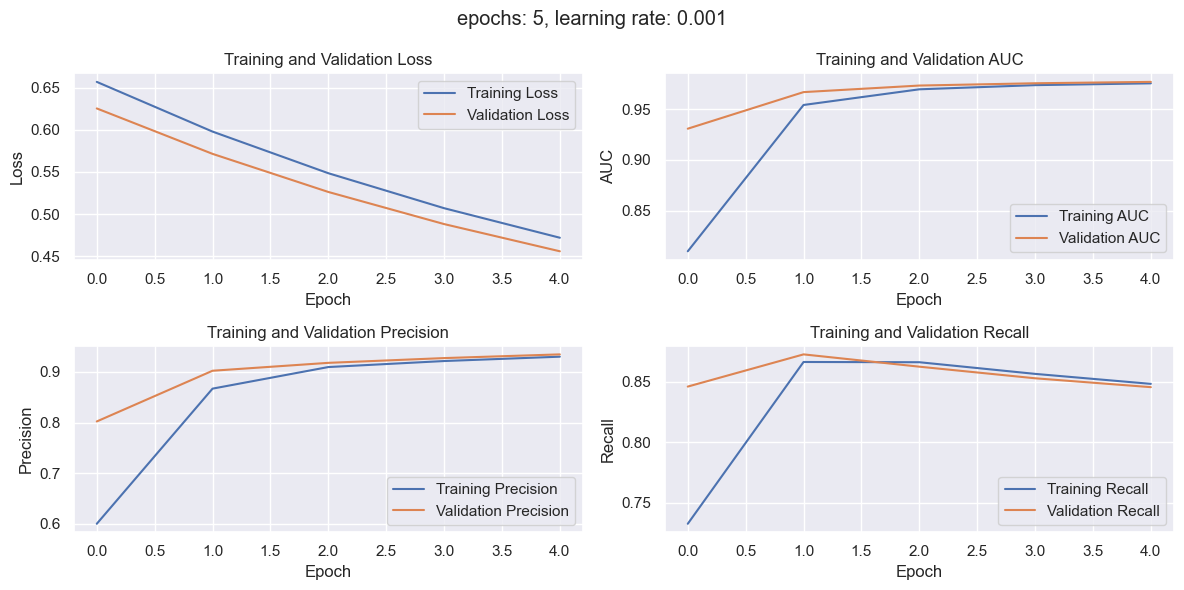

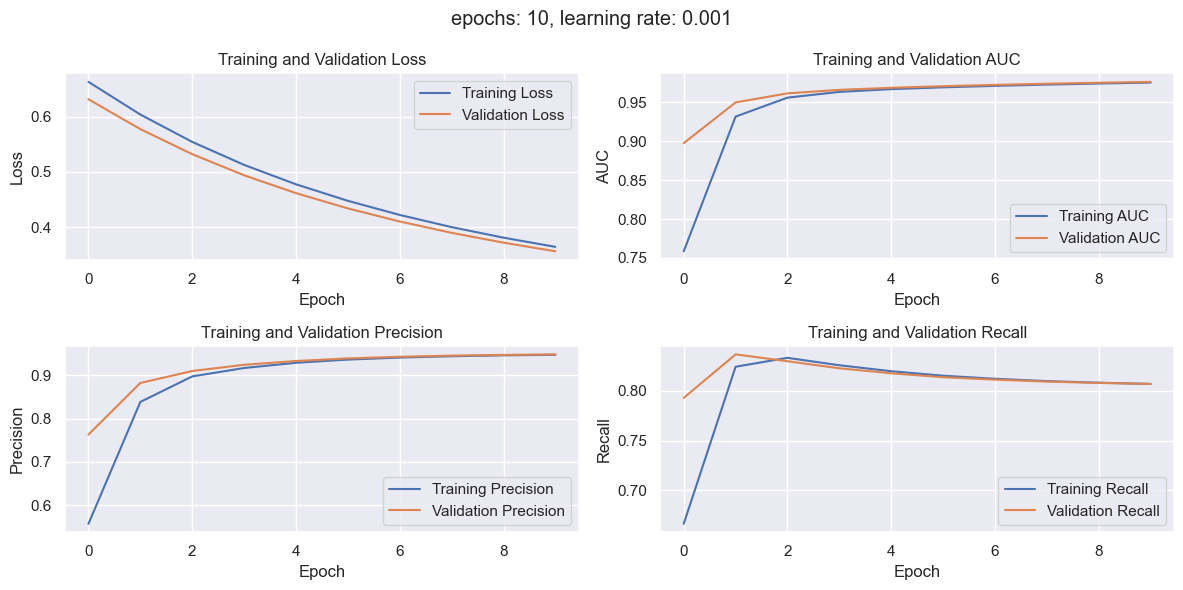

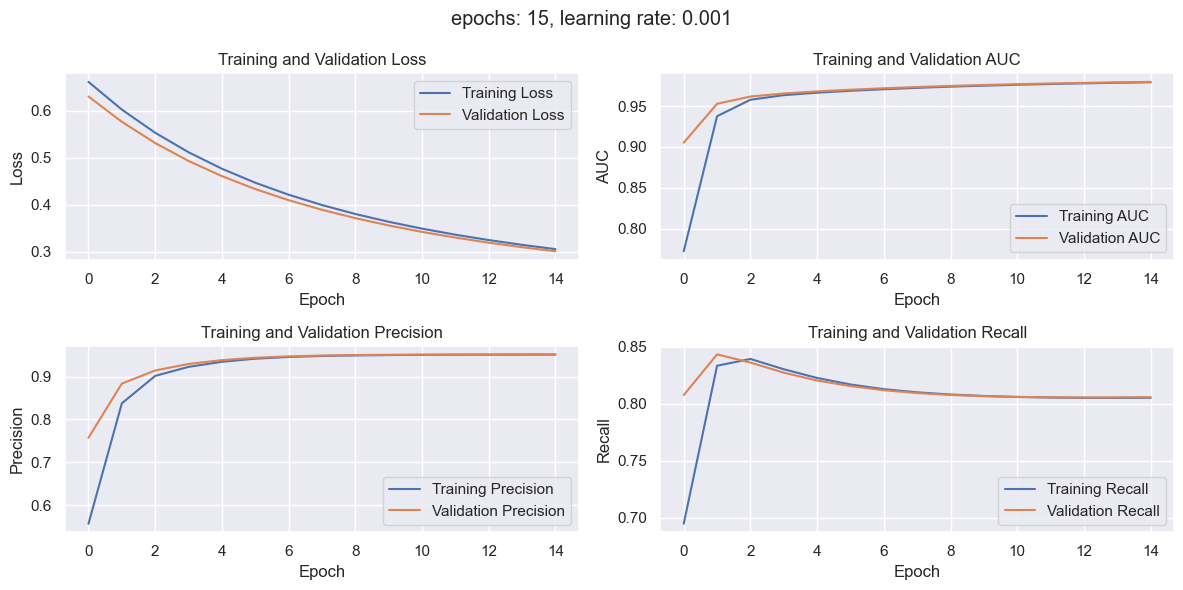

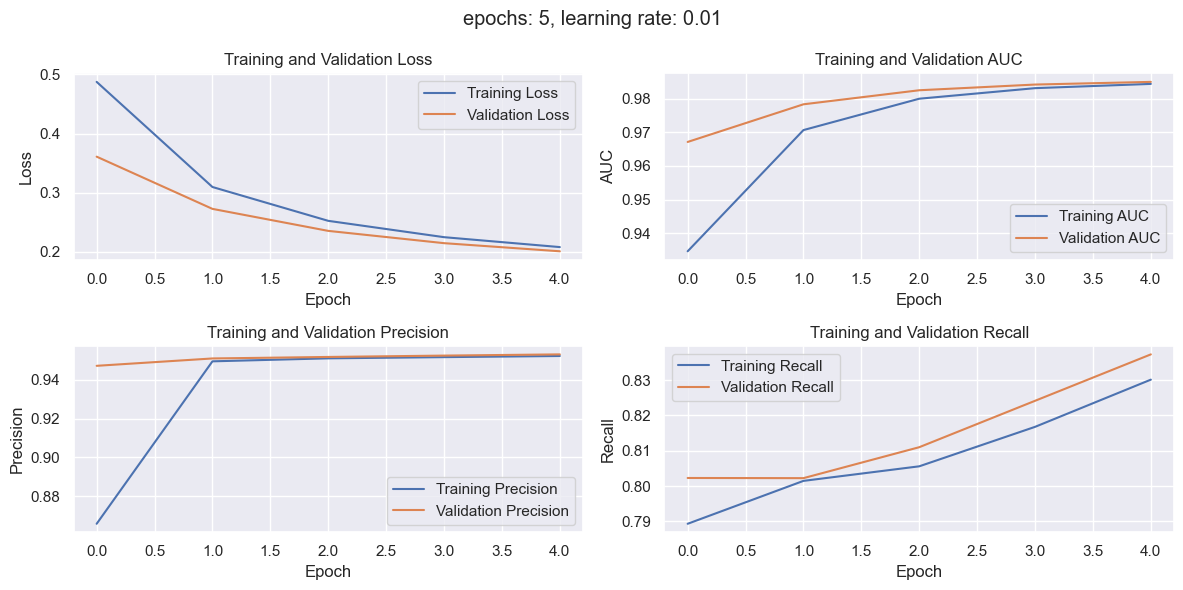

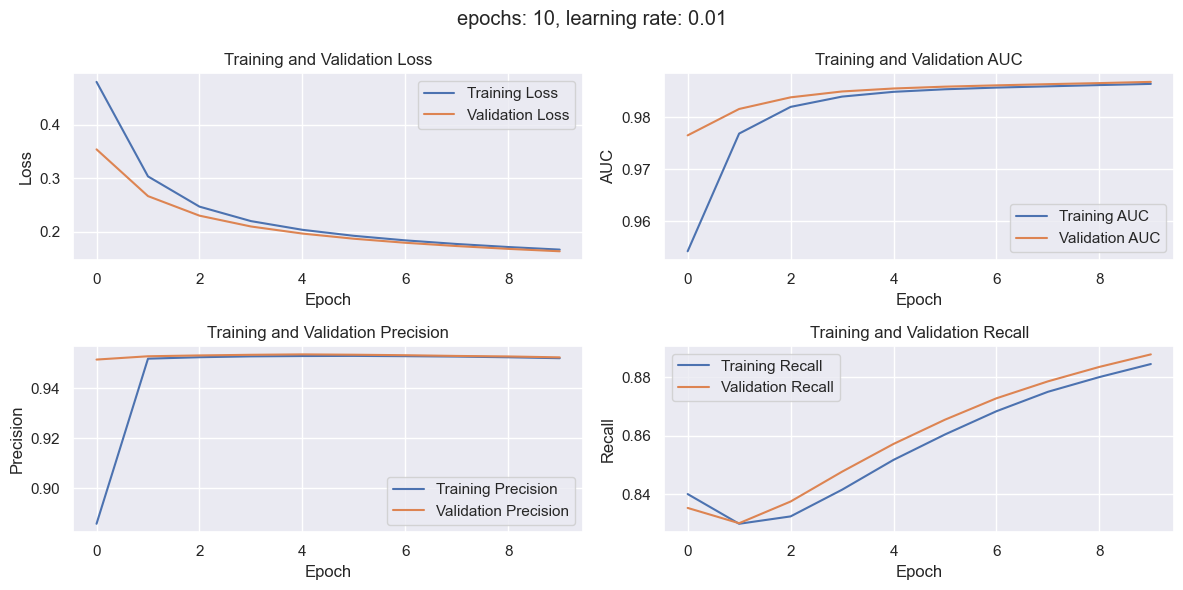

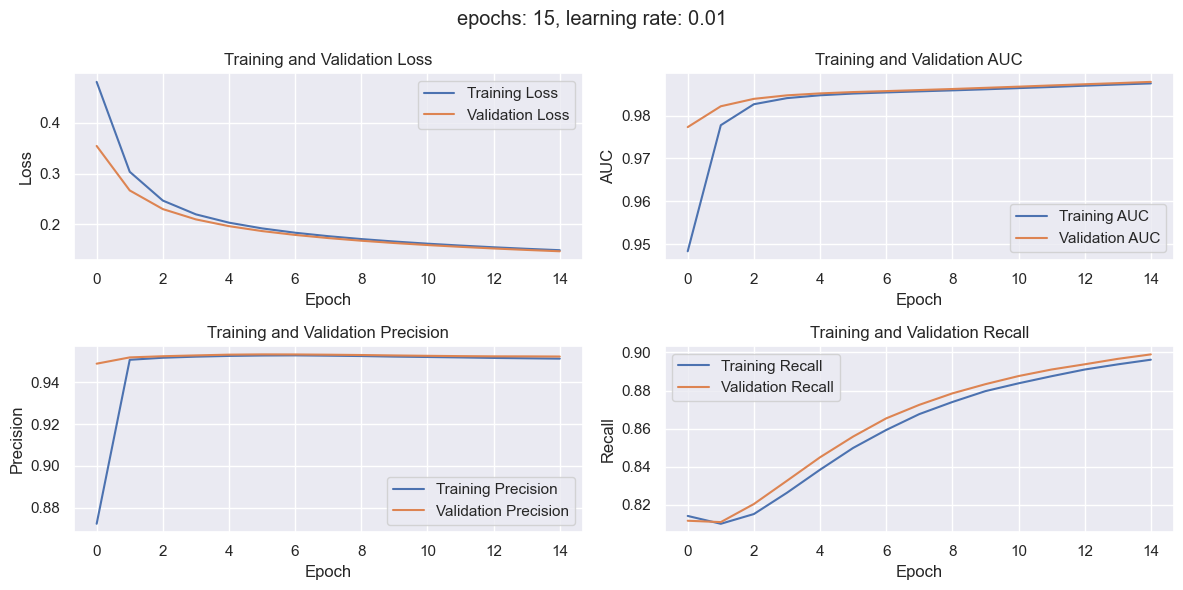

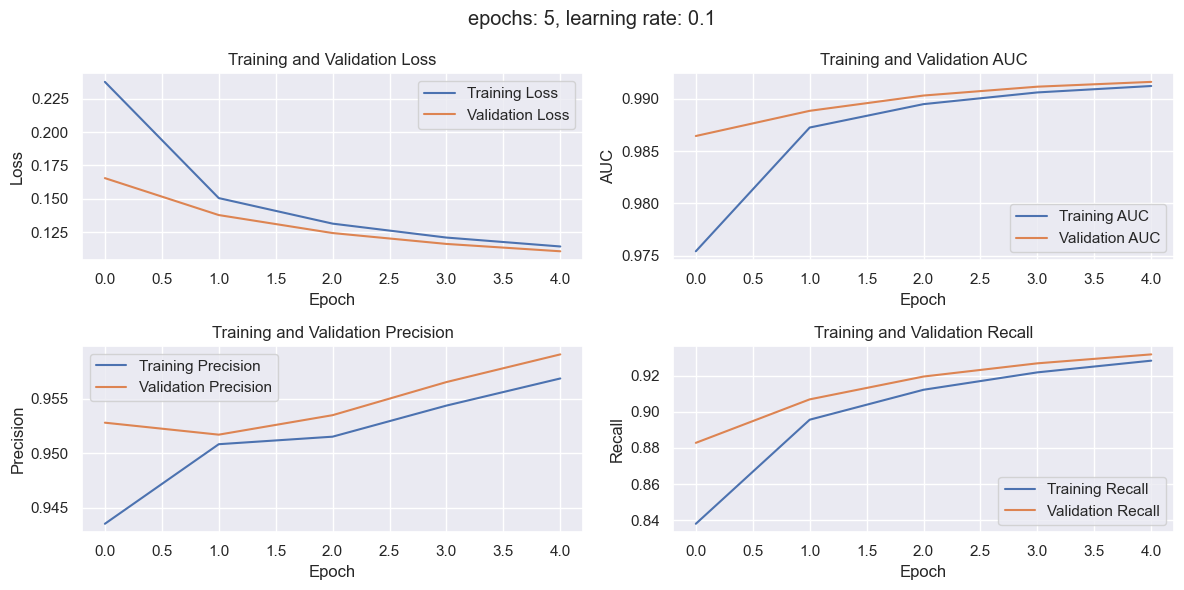

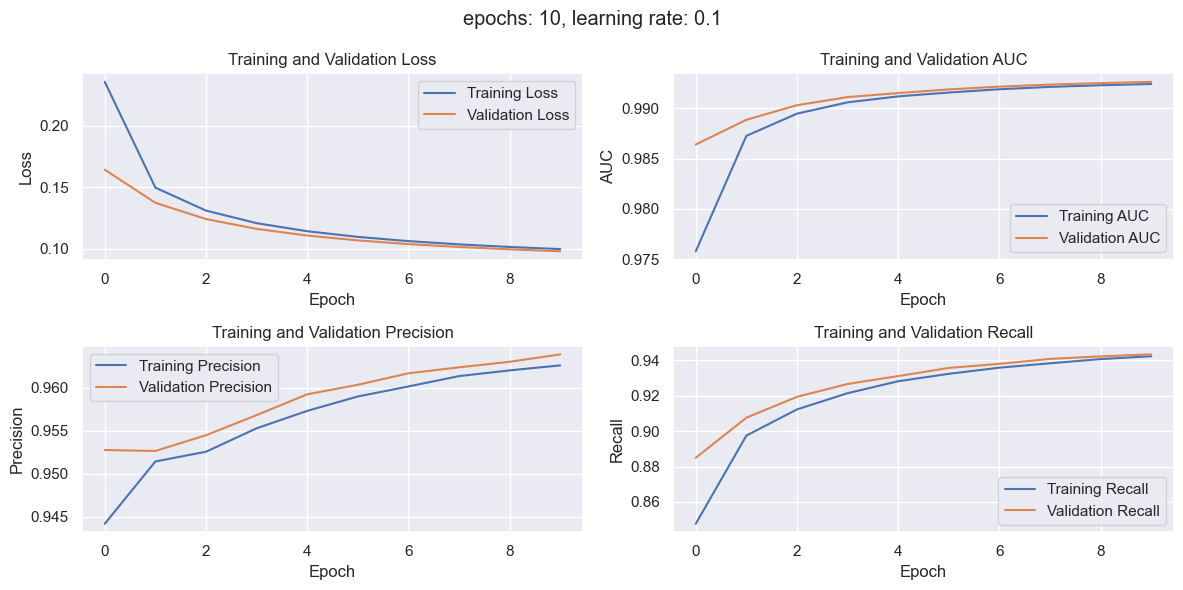

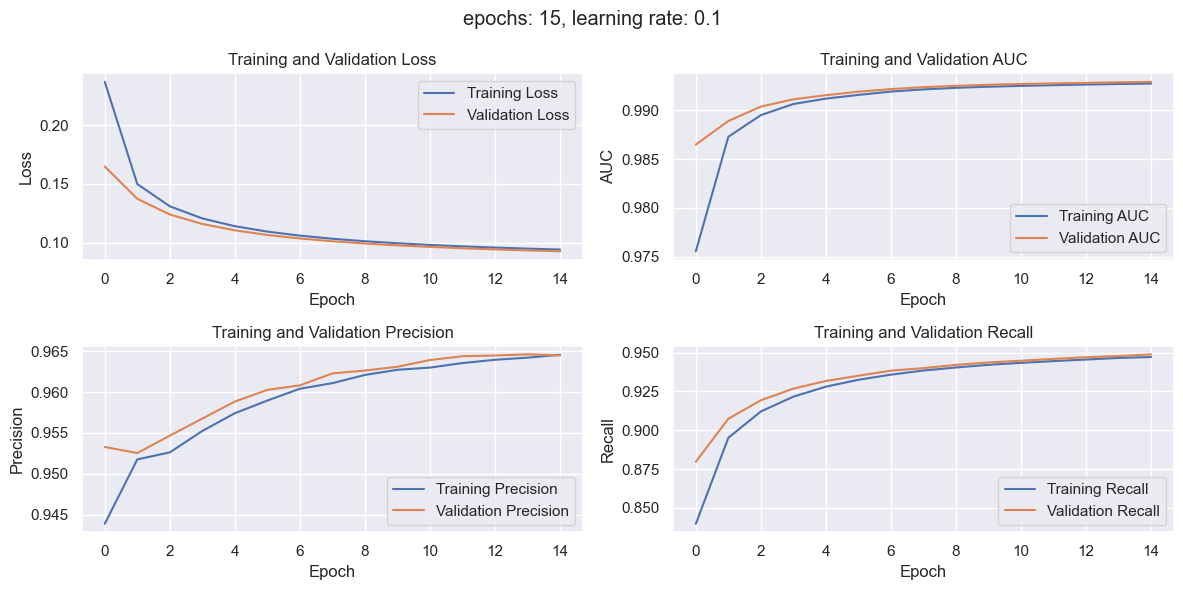

In [18]:
sns.set(style="darkgrid")
for result in results:
    plt.figure(figsize=(12, 6))


    plt.suptitle(f"epochs: {result.get('epochs')}, learning rate: {result.get('learning_rate')}")

    plt.subplot(2, 2, 1)
    plt.plot(result.get("metrics").history["loss"], label='Training Loss')
    plt.plot(result.get("metrics").history["val_loss"], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(result.get("metrics").history["auc"], label='Training AUC')
    plt.plot(result.get("metrics").history["val_auc"], label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(result.get("metrics").history["precision"], label='Training Precision')
    plt.plot(result.get("metrics").history["val_precision"], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(result.get("metrics").history["recall"], label='Training Recall')
    plt.plot(result.get("metrics").history["val_recall"], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()


    plt.tight_layout()
    plt.show()
    

Results for Learning Rate: 0.1, Epochs: 5
Training Metrics:
The initial 5 epochs show significant improvements in various metrics. The loss decreases, and AUC, precision, and recall all exhibit positive trends. These improvements indicate that the model is learning from the data and adapting its parameters to better fit the training set.

Validation Metrics:
Validation metrics also show promising results after 5 epochs. The decreasing validation loss and improving AUC, precision, and recall suggest that the model generalizes well to unseen data.

Results for Learning Rate: 0.1, Epochs: 10
Training Metrics:
Extending training to 10 epochs results in continued improvements, albeit at a slower rate. The loss, AUC, precision, and recall all show positive trajectories, indicating ongoing refinement of the model.

Validation Metrics:
Validation metrics maintain consistency with training metrics, showcasing that the model's performance extends beyond the training set. The decreasing validation loss and improvements in AUC, precision, and recall suggest that the model is still benefiting from additional training.

Results for Learning Rate: 0.1, Epochs: 15
Training Metrics:
Training for 15 epochs demonstrates marginal improvements in metrics. The loss continues to decrease, but AUC, precision, and recall show slower rates of improvement, indicating potential diminishing returns.

Validation Metrics:
Validation metrics exhibit similar trends, with diminishing returns after 10 epochs. While the model continues to generalize, the rate of improvement decreases.

Discussion on Sufficient Epochs:
The observed trends suggest that the model achieves significant gains within the initial 5 to 10 epochs. Beyond this point, the rate of improvement diminishes, indicating that additional epochs may offer limited benefits. This phenomenon is often referred to as "early stopping," where training is halted once the model's performance plateaus, preventing overfitting.

Considering computational efficiency and avoiding overfitting, it seems reasonable to stop training around 10 epochs. This allows the model to capture the underlying patterns in the data without unnecessary computational costs.

6 Epochs: Stopping at 6 epochs appears to capture substantial improvements in the model. The trends indicate that the model is learning effectively, and additional epochs may provide diminishing returns.

10 Epochs: Extending training to 10 epochs could lead to further refinement, particularly in fine-tuning the model's parameters. However, this comes with increased computational cost.

Stopping at 6 epochs seems to strike a balance between efficiency and model performance

Comparison with Learning Rate: 0.1
Learning Rate: 0.01 vs. 0.1
Loss: The model with a learning rate of 0.01 generally achieves lower training and validation losses, indicating better convergence.
AUC: Both learning rates show similar positive trends in AUC, but 0.01 may provide slightly better discrimination ability.
Precision and Recall: Both learning rates lead to improved precision and recall, but 0.01 appears to offer slightly better performance.

The learning rate of 0.001 demonstrates effective learning, showing superior convergence and performance across key metrics compared to 0.01 and 0.1.
While both 0.01 and 0.1 show reasonable performance, 0.001 is a promising candidate for further experimentation and fine-tuning to optimize model performance.

In [26]:
def print_results_for_lr_and_epochs(learning_rate, epochs, results):
    print(f"\nResults for Learning Rate: {learning_rate}, Epochs: {epochs}\n")
    
    # Filter results for the specified learning rate and epochs
    lr_epochs_results = [result for result in results if result['learning_rate'] == learning_rate and result['epochs'] == epochs]

    for result in lr_epochs_results:
        # Print the metrics from history
        print("Training Metrics:")
        for metric_name, values in result['metrics'].history.items():
            print(f"{metric_name}: {values}")

        # Print validation metrics
        print("Validation Metrics:")
        for metric_name, values in result['metrics'].history.items():
            print(f"val_{metric_name}: {values}")

In [34]:
print_results_for_lr_and_epochs(0.001, 5, results)


Results for Learning Rate: 0.001, Epochs: 5

Training Metrics:
loss: [0.656745970249176, 0.5978308916091919, 0.5485172271728516, 0.5070672631263733, 0.47204336524009705]
auc: [0.8099087476730347, 0.9539722800254822, 0.9694007635116577, 0.973503053188324, 0.9752947092056274]
precision: [0.5999878644943237, 0.8669894933700562, 0.9096373915672302, 0.9215182065963745, 0.9301149249076843]
recall: [0.7326810956001282, 0.8665210604667664, 0.8663264513015747, 0.856685996055603, 0.8484281897544861]
val_loss: [0.6252790093421936, 0.5714442729949951, 0.5262957215309143, 0.4882463812828064, 0.45599645376205444]
val_auc: [0.9306178092956543, 0.9666440486907959, 0.9730994701385498, 0.9753631353378296, 0.976719081401825]
val_precision: [0.8021577596664429, 0.9023340344429016, 0.9179291129112244, 0.9273568987846375, 0.9346657395362854]
val_recall: [0.8461750149726868, 0.8728141784667969, 0.8626400232315063, 0.8530454039573669, 0.8456970453262329]
Validation Metrics:
val_loss: [0.656745970249176, 0.59

In [35]:
print_results_for_lr_and_epochs(0.001, 10, results)


Results for Learning Rate: 0.001, Epochs: 10

Training Metrics:
loss: [0.6628371477127075, 0.6036844849586487, 0.5541658401489258, 0.5125399231910706, 0.4773613512516022, 0.44745317101478577, 0.42186394333839417, 0.3998270034790039, 0.38072746992111206, 0.3640702962875366]
auc: [0.7585947513580322, 0.9313958883285522, 0.9557057023048401, 0.963092565536499, 0.966623067855835, 0.9689315557479858, 0.9708206653594971, 0.9724396467208862, 0.973800539970398, 0.975030779838562]
precision: [0.5573263764381409, 0.8382747769355774, 0.8970978856086731, 0.9164583086967468, 0.9285045266151428, 0.9358640313148499, 0.9405131936073303, 0.9435940980911255, 0.9456793069839478, 0.9469277262687683]
recall: [0.6664524078369141, 0.8243743777275085, 0.8333107233047485, 0.8258569240570068, 0.8198678493499756, 0.8153407573699951, 0.8122604489326477, 0.8099149465560913, 0.8083171844482422, 0.8070420026779175]
val_loss: [0.6313378810882568, 0.5772847533226013, 0.5319474935531616, 0.49373432993888855, 0.46134009

In [36]:
print_results_for_lr_and_epochs(0.001, 15, results)


Results for Learning Rate: 0.001, Epochs: 15

Training Metrics:
loss: [0.6611977219581604, 0.6023699045181274, 0.5531205534934998, 0.5117143988609314, 0.4767158031463623, 0.4469556510448456, 0.4214882254600525, 0.3995518982410431, 0.38053613901138306, 0.3639478087425232, 0.34939002990722656, 0.3365398645401001, 0.32513439655303955, 0.3149576187133789, 0.30583369731903076]
auc: [0.7725125551223755, 0.9376193284988403, 0.957738995552063, 0.9633510708808899, 0.966352641582489, 0.9686709642410278, 0.9705824851989746, 0.9722925424575806, 0.9737489819526672, 0.9749693870544434, 0.9760675430297852, 0.9769869446754456, 0.9778022766113281, 0.9784894585609436, 0.9791055917739868]
precision: [0.5566279888153076, 0.8375040292739868, 0.9016477465629578, 0.9226776361465454, 0.9345030784606934, 0.9417359828948975, 0.9457646012306213, 0.9481135010719299, 0.9493721723556519, 0.9501709938049316, 0.9506569504737854, 0.9509887099266052, 0.9511081576347351, 0.9512361884117126, 0.9513351917266846]
recall: 

### ADDITIONAL PART

In [30]:
#history = model.fit(X_train_tensor, y_train_tensor, batch_size=32, epochs=10, validation_data=(X_test_tensor, y_test_tensor))

#model.evaluate(X_test_tensor, y_test_tensor)

In [52]:
# Clear previous TensorFlow session
#tf.keras.backend.clear_session()

In [53]:
#model = Sequential()
#model.add(InputLayer(input_shape=(doc2vec_model.vector_size,)))
#model.add(Dense(128, activation="relu"))
#model.add(Dense(7, activation=tf.nn.sigmoid))
#optimizer = tf.keras.optimizers.SGD()
#model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [54]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [55]:
#mlb = MultiLabelBinarizer()
#y_train_mlb = mlb.fit_transform(y_train)
#y_test_mlb = mlb.fit_transform(y_test)

In [56]:
#X_train_tensor = tf.convert_to_tensor(X_train)
#X_test_tensor = tf.convert_to_tensor(X_test)
#y_train_tensor = tf.convert_to_tensor(y_train_mlb)
#y_test_tensor = tf.convert_to_tensor(y_test_mlb)

In [57]:
#history = model.fit(X_train_tensor, y_train_tensor, batch_size=32, epochs=10, validation_data=(X_test_tensor, y_test_tensor))
#model.evaluate(X_test_tensor, y_test_tensor)

Epoch 1/10
5098/5098 [==============================] - 14s 3ms/step - loss: 0.2383 - auc: 0.9845 - precision: 0.9485 - recall: 0.9357 - val_loss: 0.1102 - val_auc: 0.9913 - val_precision: 0.9647 - val_recall: 0.9523
Epoch 2/10
5098/5098 [==============================] - 12s 2ms/step - loss: 0.0941 - auc: 0.9922 - precision: 0.9667 - recall: 0.9536 - val_loss: 0.0875 - val_auc: 0.9930 - val_precision: 0.9663 - val_recall: 0.9555
Epoch 3/10
5098/5098 [==============================] - 11s 2ms/step - loss: 0.0852 - auc: 0.9935 - precision: 0.9678 - recall: 0.9561 - val_loss: 0.0849 - val_auc: 0.9934 - val_precision: 0.9677 - val_recall: 0.9559
Epoch 4/10
5098/5098 [==============================] - 11s 2ms/step - loss: 0.0836 - auc: 0.9936 - precision: 0.9682 - recall: 0.9569 - val_loss: 0.0839 - val_auc: 0.9935 - val_precision: 0.9675 - val_recall: 0.9574
Epoch 5/10
5098/5098 [==============================] - 11s 2ms/step - loss: 0.0828 - auc: 0.9937 - precision: 0.9683 - recall: 0.95

[0.08239831775426865,
 0.9936915636062622,
 0.9672003388404846,
 0.9588132500648499]

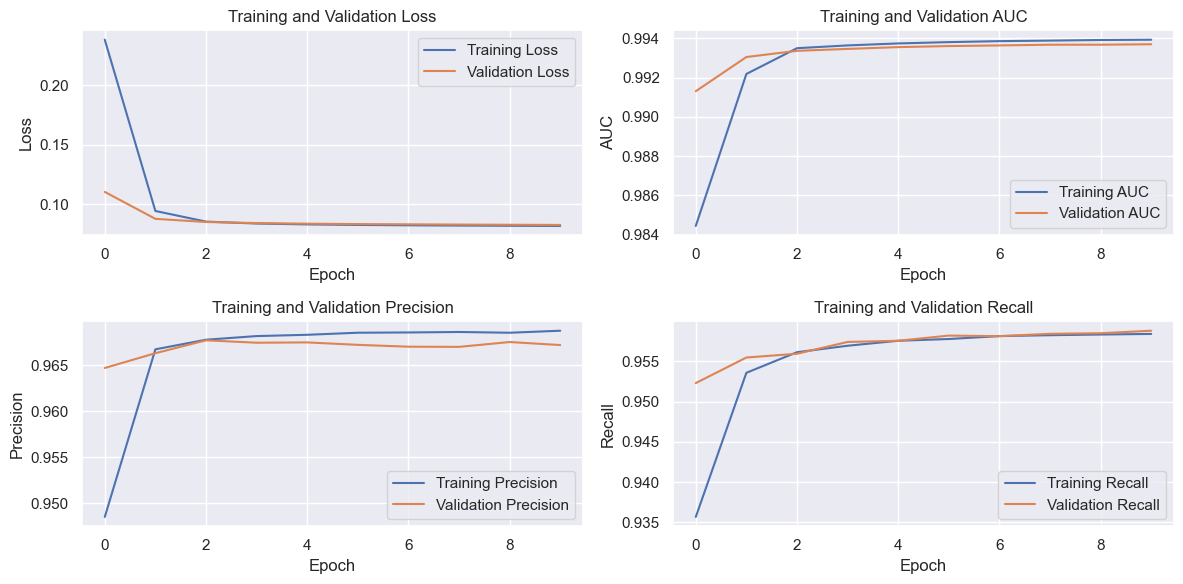

In [60]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_auc = history.history["auc"]
validation_auc = history.history["val_auc"]
training_precision = history.history['precision']
validation_precision= history.history['val_precision']
training_recall = history.history["recall"]
validation_recall = history.history["val_recall"]

sns.set(style="darkgrid")

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(training_auc, label='Training AUC')
plt.plot(validation_auc, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(training_precision, label='Training Precision')
plt.plot(validation_precision, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(training_recall, label='Training Recall')
plt.plot(validation_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()


plt.tight_layout()
plt.show()

In [63]:
#tf.keras.backend.clear_session()

<div style="text-align: justify">To compile the model, we'll need to set a few parameters:<br>

- Optimizer: The optimizer adjusts the weights during training to minimize the loss function.
- Loss Function: For multi-class classification, 'categorical_crossentropy' is commonly used.
- Metrics: These are used to judge the performance of the model. For classification tasks, 'accuracy' is a standard metric.</div>

**4.3. Fine-tune the last layer of the network on the supervised training set for N epochs.**

<div style="text-align: justify">Once the dataset was divided into training and validation sets. Converted the data into TensorFlow tensors. Fit the neural network model using the training set, specifying the number of epochs and batch size.</div>

To facilitate model training, we convert our tokenized and preprocessed data into TensorFlow tensors. This conversion involves the extraction of vectors and subsequent conversion into arrays, catering to the TensorFlow model's input requirements.

In [ ]:
doc2vec_model = Doc2Vec.load('trained_doc2vec_model.model') 

In [ ]:
df_doc2vec = df_session_cleaned.copy().drop(columns=["full_session", "first_timestamp"])
df_doc2vec.insert(1, "doc2vec_vector", df_session_cleaned['full_session'].apply(doc2vec_model.infer_vector))
df_doc2vec

In [ ]:
#FIXME REMOVE THIS PART
# Load the trained Doc2Vec model
doc2vec_model = Doc2Vec.load('trained_doc2vec_model.model') 

# Function to infer vectors for each document
def infer_vector(text):
    return doc2vec_model.infer_vector(text.split())

# Apply inference to each text and store the vectors in a new column
data['doc2vec_vectors'] = data['full_session'].apply(infer_vector)

# Extract vectors and convert to array for modeling
X = np.array(data['doc2vec_vectors'].tolist())

In [ ]:
X = df_doc2vec['doc2vec_vector']  
y = df_doc2vec['Set_Fingerprint'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes 
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

In [ ]:
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.transform(y_test)

In [ ]:
X_train_array = np.array(X_train.tolist())
X_test_array = np.array(X_test.tolist())

X_train_tensor = tf.convert_to_tensor(X_train_array)
X_test_tensor = tf.convert_to_tensor(X_test_array)
y_train_tensor = tf.convert_to_tensor(y_train_mlb)
y_test_tensor = tf.convert_to_tensor(y_test_mlb)

Gradient Descent:
TensorFlow's optimizer, such as 'adam,' already performs gradient descent during training, so we don't need to explicitly implement gradient descent.

To explore the fine-tuning process, the original model was cloned, creating a new model (cloned_model). The cloned model was compiled, and fine-tuning was conducted on the last layer. This step involved training the model on the supervised training set for 10 epochs.

The epoch of model training commences as we replicate the architecture and compile the model for training. We embark on an iterative process, honing the model's capacity to discern intents from sessions.

In [ ]:
cloned_model = clone_model(model)
cloned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The training results were analyzed by observing the learning curves over the 10 epochs. The evolution of loss and accuracy on both the training and validation sets provided insights into the model's convergence and performance.

In [ ]:
# Train the model
history = cloned_model.fit(X_train_tensor, y_train_tensor, epochs=10, batch_size=32, validation_data=(X_test_tensor, y_test_tensor))
#Epoch: An epoch represents one complete pass through the entire training dataset.
#Number of Epochs: It determines the number of times the learning algorithm will work through the entire training dataset
#Batch: The training data is divided into batches. The model is trained on each batch, and the weights are updated after each batch.
#Batch Size: It's the number of samples processed before the model is updated. Smaller batch sizes offer faster training but may be less stable than larger batch sizes.
#model.fit(): This function fits the model on the training data. It iterates over a fixed number of epochs and updates the model's weights based on the backpropagation of errors.

Loss and Accuracy Trends:

Training Loss:
Decreases from an initial value of 189.9254 to 12626.7578 over the 10 epochs.
Training Accuracy:
Starts at 75.37% and drops to 47.99% by the end of the training.

Validation Loss and Accuracy:

Validation Loss:
Increases from 439.7433 to 13605.3906 during the training process.
Validation Accuracy:
Exhibits fluctuations, reaching a peak of 91.45% in the final epoch.

Overfitting:
The model appears to be overfitting, as indicated by the increasing validation loss and decreasing training accuracy. This suggests that the model is fitting the training data too closely

Validation Accuracy Fluctuations: 
The validation accuracy shows fluctuations, indicating potential instability in the model's performance.

<div style="text-align: justify">When using <i>'tf.function'</i>, TensorFlow creates a graph representation of the computation for optimization. However, certain operations, especially those involving variable creation, can cause issues within the graph when the function is called multiple times. <br><br>
Creating a new model instance or cloning the model before train it again helps to avoid conflicts caused by the pre-existing variables or the TensorFlow graph. This approach prevents potential issues that might arise from reusing the same model object within a <i>'tf.function'</i> context. Essentially, it ensures that the new training session starts with a fresh model instance, avoiding any residual state from previous training sessions that might interfere with the current one.</div><br>

**4.4 Plot the learning curves on training and validation set. After how many epochs should we stop the training?**

<div style="text-align: justify">The Matplotlib library was used to create visualisations of training and validation losses, as well as training and validation accuracy over epochs. These plots are helpful to understand how the model learns over time, showing convergence and possible overfitting or underfitting.</div><br>

<div style="text-align: justify">(Learning curves are used to understand the changes in 'loss' and 'accuracy' at each epoch. If the training accuracy is high but the validation accuracy is low, it may indicate overfitting, whereas consistently low accuracy for both may suggest underfitting).</div><br>

<div style="text-align: justify">[In summary, the process involved preparing the text data, training a Doc2Vec model to generate embeddings, constructing and training a neural network model for intent classification, and visualizing the model's learning progress. The aim is to build a model that effectively identifies attack session intents using text data and Doc2Vec embeddings.]</div>

In [ ]:
# Access the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['precision']
validation_accuracy = history.history['val_precision']

# Set up Seaborn style
sns.set(style="darkgrid")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

OTHER POSSIBLE SOLUTION to improve

In [ ]:
cloned_model_improvement = clone_model(model)
# Compile the model with a different optimizer and learning rate
optimizer = tf.keras.optimizers.SGD()
cloned_model_improvement.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Add dropout layers
model.add(Dropout(0.5)) 

In [ ]:
#Implement Early Stopping: Monitor the validation loss and stop training when it ceases to improve.
# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = cloned_model_improvement.fit(X_train_tensor, y_train_tensor, epochs=10, batch_size=64, validation_data=(X_test_tensor, y_test_tensor), callbacks=[early_stopping])

precision, recall, and F1-score for a more comprehensive assessment of model performance.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Get predictions
predictions = cloned_model_improvement.predict(X_test_tensor)

# Convert probabilities to binary predictions using thresholding
threshold = 0.5
predictions_binary = (predictions > threshold).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_mlb, predictions_binary, average='weighted')
recall = recall_score(y_test_mlb, predictions_binary, average='weighted')
f1 = f1_score(y_test_mlb, predictions_binary, average='weighted')

print(f'Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

<left><b><font size=4>Final Considerations of Section 4<b><left>

The initial model displayed promising results with high validation accuracy but raised concerns about potential overfitting due to a significant gap between training and validation accuracy.

#### Improvement Steps:

- **Model Architecture Adjustment:**
  - *Dropout Layers:* Incorporated dropout layers to introduce regularization, mitigating overfitting.
  - *Layer Complexity:* Adjusted the model's architecture by fine-tuning layer complexities for improved balance.

- **Optimization Strategies:**
  - *Learning Rate Tuning:* Experimented with different learning rates to enhance stability during training.
  - *Adam Optimizer:* Transitioned to the Adam optimizer for potentially faster convergence.

- **Early Stopping Implementation:**
  - Introduced early stopping to monitor validation loss, preventing prolonged training that might lead to overfitting.

- **Evaluation Metrics Shift:**
  - *Weighted Metrics:* Moved from overall accuracy to weighted metrics (precision, recall, and F1-score) for better insight into class-specific performance.

  
  #### Post-Improvement Model Assessment:

- **Training Accuracy (Epochs 1-4):** ~48.03%
- **Validation Accuracy (Epochs 1-4):** ~57.06%
- **Challenges:** While the overfitting concern has reduced, there's room for improvement in overall accuracy.

##### Precision, Recall, and F1-Score Analysis:

- **Precision:** Achieving a high precision of *95.85%* indicates the model's ability to correctly classify positive instances.
- **Recall:** A recall of *41.45%* suggests the model's capability to capture true positive instances is lower.
- **F1-Score:** The F1-score of *53.62%* provides a balanced measure considering both precision and recall.



<left><b><font size=4>Final Considerations of the Project<b><left>